# Self Organizing Maps

## Table of Contents
- [<h3>Setting up Notebook</h3>](#1.0)
    - [<h4>Import Section</h4>](#1.1)

- [<h3>Data Preparation</h3>](#2.0)    
- [<h3>Visualising the Data</h3>](#3.0)
    
- [<h3>Class Definition </h3>](#4.0)
    - [<h4>SOM Base Class </h4>](#4.1)
    - [<h4>One Dimensional SOM Class </h4>](#4.2)
    
- [<h3>Implementation</h3>](#5.0)
    - [<h4>Original Code Implementation</h4>](#5.1)
    - [<h4>custom code Area </h4>](#5.2)

- [<h3>Notes</h3>](#6.0)
    


### 1. Setting up the Notebook <a id="1.0"></a>

#### 1.1 Import Section <a id="1.1"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import glob
import cv2

## 2. Data Preparation <a id ='2.0'></a>

In [5]:
data = [[0.2, 0.1],[0.15, 0.2], [0.4, 0.45], [0.2, 0.77], [0.5, 0.9], 
         [0.83, 0.65], [0.7, 0.5], [0.82, 0.35], [0.65, 0.23], [0.6, 0.28]]
data = np.array(data)

In [6]:
pd.DataFrame(data)

,0,1
0,0.20,0.10
1,0.15,0.20
2,0.40,0.45
3,0.20,0.77
4,0.50,0.90
5,0.83,0.65
6,0.70,0.50
7,0.82,0.35
8,0.65,0.23
9,0.60,0.28


### 3.0 Visualizing the Data <a id ='3.0'></a>

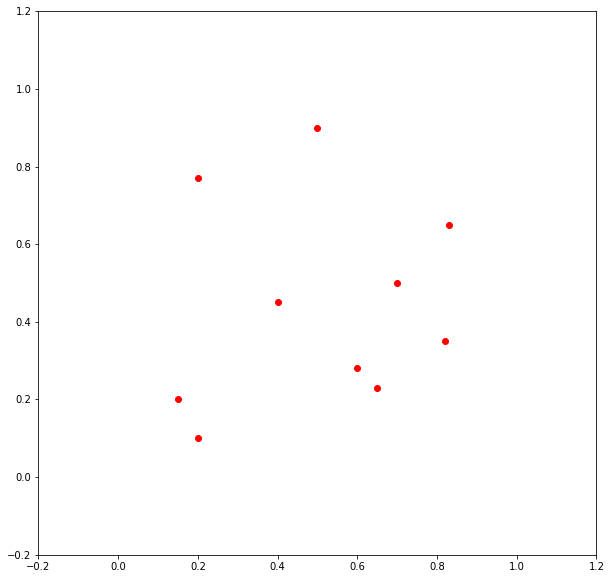

In [7]:
plt.figure(figsize=(10,10))
plt.plot(data[:, 0], data[:, 1], 'ro')
plt.axis([-0.2, 1.2, -0.2, 1.2])
plt.show()

## 4. Class Definition <a id ='4.0'></a>

### 4.1 SOM Base Class <a id ='4.1'></a> (som.py)

In [8]:
class SOM:
    """
    SOM is a parent class for Self Organizing Maps algorithm implementation with some basic functionalities

    Functions:
        -> find_euclidean_distance()    : A function to calculate the euclidean distance between two points
        -> find_BMU()                   : A function to compute the Best matching Unit(BMU)
        -> update_weights()             : A function to perform weights updating
        -> compute_learning_rate()      : A function to compute a decaying learning rate after every epoch
        -> compute_neighbourhood_size() : A function to compute a decaying neighbourhood radius after every epoch
    """

    def __init__(self):
        self.lr = None
        self.size = None
        self.weights = None
        self.lr_const = None
        self.time_const = None
        self.epochs_const = None
        self.neighborhood_prob = None
        self.neighbors_radius_const = None
        print("Created an SOM class object...!")

    @staticmethod
    def find_euclidean_distance(d1: np.array, d2: np.array) -> np.array:
        """
        A static method to find distance between two points or two array of data points

        Args:
            d1: np.array
                data1
            d2: np.array
                data2

        Returns: None

        """
        return np.sqrt(np.sum((d1 - d2) ** 2, axis=1, keepdims=True))

    @staticmethod
    def find_BMU(dist: np.array) -> np.array:
        """
        A static method to find the index of an array with minimum heuristics

        Args:
            dist: np.array
                An array of distance values

        Returns: int

        """
        return np.argmin(dist)

    def update_weights(self, data_point: np.array) -> None:
        """
        A method to update weights of the model

        Args:
            data_point: np.array
                data

        Returns: None

        """
        self.weights += self.lr * self.neighborhood_prob * (data_point - self.weights)

    def compute_learning_rate(self, current_epoch: int) -> float:
        """
        A method to compute learning rate based on the current epoch

        Args:
            current_epoch: int
                Value of the current epoch

        Returns: float

        """
        return self.lr_const * np.exp(-current_epoch / self.epochs_const)

    def compute_neighborhood_size(self, current_epoch: int) -> float:
        """
        A method to compute neighborhood size for updating weighting based on current epoch

        Args:
            current_epoch:

        Returns: float

        """
        return self.neighbors_radius_const * np.exp(-current_epoch / self.time_const)

 ### 4.2 One Dimensional SOM Class <a id ='4.2'></a> (som_1d.py)

In [9]:
class SOM_1D(SOM):
    """
    SOM_1D is a Child class inheriting SOM parent class for performing 1D Self Organizing Maps algorithm implementation

    Functions:
        -> initializer()                : A function to initialise all the required parameters to perform 1D SOM fitting
        -> compute_neighbourhood_prob() : A function to compute the gaussian probability for neighbourhood in 1D
        -> fit()                        : A function to perform 1D SOM fitting to the given data
    """

    def __init__(self):
        super().__init__()
        self.len = None
        self.BMU = None
        self.dist = None
        self.data = None
        self.weights = None
        self.data_dim = None
        self.data_set = None
        self.save_file = False
        self.save_count = 1
        self.neighborhood_prob = None

        # -----> Variables initialize <----- #
        self.N = 50
        self.sample_count = 0.5
        self.lattice = np.arange(self.N)

        # -----> Flags <----- #
        self.loop_path = True
        self.random_sample = False
        self.save_file = False
        self.frames = {}
        self.weights_df = None

        # -----> Hyper parameter Constants <----- #
        self.lr_const = 0.04
        self.epochs_const = 1000
        self.neighbors_radius_const = 0

    def initializer(self, data: np.array) -> None:
        """
        Initialise the data and data associated variables
        Args:
            data: np.array
                Data set

        Returns: None

        """
        self.len = data.__len__()
        self.N = 50 if 50 > self.len*5 else self.len*5
        self.neighbors_radius_const = self.neighbors_radius_const if self.neighbors_radius_const > 2*self.len else 2*self.len
        self.data_dim = data.shape
        self.data_set = data.copy()

        self.lattice = np.arange(self.N)
        self.weights = np.min(data, axis=0) \
                       + (np.max(data, axis=0) - np.min(data, axis=0)) \
                       * np.random.ranf((self.N, 2))

        # -----> Hyper parameter Constants <----- #
        self.time_const = self.epochs_const / np.log(self.neighbors_radius_const)
        if self.random_sample:
            idx = np.random.choice(np.arange(self.len), int(self.sample_count * self.len))
            self.data = data[idx]
        else:
            self.data = data.copy()

    def compute_neighborhood_prob(self, index: int, epoch: int) -> np.array:
        """

        Args:
            index: int
                BMU value
            epoch: int
                Current epoch

        Returns: np.array
            Returns an array of neighborhood probability
        """
        sigma = self.compute_neighborhood_size(epoch)
        lateral_dist = abs(self.lattice - index)
        if self.loop_path:
            lateral_dist = np.minimum(lateral_dist, self.N - lateral_dist)
        return np.exp(-lateral_dist ** 2 / (2 * sigma ** 2)).reshape(-1, 1)

    def fit(self) -> None:
        """
        It implements the 1D SOM

        Returns: None

        """
        for epoch in range(1, self.epochs_const + 1):
            np.random.shuffle(self.data)
            if epoch < 5 or epoch % self.save_count == 0:
                self.frames[epoch] = self.weights.copy()
            for data_point in self.data:
                self.dist = self.find_euclidean_distance(data_point, self.weights)
                self.BMU = self.find_BMU(self.dist)
                self.neighborhood_prob = self.compute_neighborhood_prob(self.BMU, epoch)
                self.lr = self.compute_learning_rate(epoch)
                self.update_weights(data_point)

        if self.save_file:
            self.weights_df = pd.DataFrame(self.frames)


 ### 4.3 Utility.py <a id ='4.3'></a>

In [10]:
def frames_to_video(directory: str, file_name: str):
    """
    A function to create a video of the
    Args:
        directory: string
            Directory of the folder that contains individual frames
        file_name: string
            Desired name for the output video file
    Returns: None

    """
    img_array = []
    for filename in glob.glob(directory + '/*.png'):
        img = cv2.imread(filename)
        img_array.append(img)
    out = cv2.VideoWriter(file_name + '.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, img_array[0].shape)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


def implement_som1d(data: np.array) -> SOM_1D:
    """
    A function to Implement SOM 1D
    Args:
        data: np.array
            Input Data

    Returns: Object
        SOM_1D Object

    """
    som_obj = SOM_1D()
    som_obj.initializer(data)
    som_obj.fit()
    return som_obj


def save_data(data: list or np.array, path: str, file_name: str = 'data', file_format: str = 'csv') -> None:
    """
    Save the weights to the disk
    Args:
        file_format: str
            file format type
        path: str
            path to root dir
        file_name: str
            File name for the file to store weights
        data: np.array
            data of the SOM Model

    Returns: None

    """
    data = pd.DataFrame(data)
    if file_format == 'csv':
        data.to_csv(path + '/models/weights/' + file_name)
    else:
        print('file format is not supported, try something else')


def load_data(path: str, file_name: str, file_format: str = 'csv') -> np.array:
    """

    Args:
        file_format: str
            File format type
        path: str
            Path to the file
        file_name:
            name of the file

    Returns: np.array
        Returns the loaded data
    """
    if file_format == 'csv':
        return pd.read_csv(path + file_name).to_numpy()[:, 1:]
    else:
        print('file format is not supported, try something else')


def visualize_data(obj: SOM_1D, title: str) -> None:
    fig = plt.figure(figsize=(10, 10))
    data, = plt.plot(obj.data[:, 0], obj.data[:, 1], 'ro')
    weights, = plt.plot(obj.weights[:, 0], obj.weights[:, 1], 'b.')
    if obj.loop_path:
        path, = plt.plot(obj.weights[:, 0], obj.weights[:, 1], 'y--')
        plt.plot([obj.weights[0, 0], obj.weights[-1, 0]], [obj.weights[0, 1], obj.weights[-1, 1]], 'y--')
    else:
        path, = plt.plot(obj.weights[:, 0], obj.weights[:, 1], 'y--')
    plt.legend([data, weights, path], ['Data', 'Weights', 'Path'])
    plt.title('Solution to Travelling Salesman Problem')
    plt.savefig('../results/output/solution.png')
    plt.show()

### 5 Implementation <a id ='5.0'></a>

#### 5.1 Original Code Implementaiton <a id ='5.1'></a>

In [16]:
def run(data: np.array = None):
    if data is None:
        data = np.array([[0.2, 0.1], [0.15, 0.2], [0.4, 0.45], [0.2, 0.77], [0.5, 0.9],
                         [0.83, 0.65], [0.7, 0.5], [0.82, 0.35], [0.65, 0.23], [0.6, 0.28],
                         [0.1, 0.25], [0.3, 0.25], [0.6, 0.3], [0.5, 0.2], [0.2, 0.4], [0.3, 0.5], [0.5, 0.5], [0.5, 0.72]])

    som = implement_som1d(data)
    visualize_data(som, 'Weights')

Created an SOM class object...!


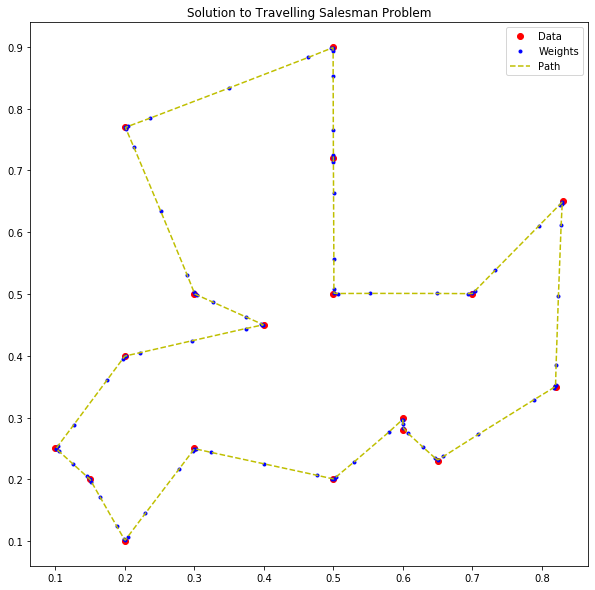

In [17]:
run()